In [1]:
from notebooks.presets import set_cwd
set_cwd()
import numpy as np
import matplotlib.pyplot as plt

from src.embeddings.magnitude_spectrum import embedding_vector
from src.embeddings.seq2img_embeddings import s2i_vector
from src.embeddings.shape_based import paa, sax
from src.data_generation.simple_data_generation import shift_time_series, shrunk_time_series

In [2]:
data_path = "data/random_sequences/random_sequences.npy"
data = np.load(data_path)

In [3]:
i = 0
n = 5
random_shifts = (np.random.random(n) - 0.5) * len(data[i]) / 4
random_shifts = random_shifts.astype(int)
random_shifts

array([  7,  47,  28, -41,  27])

In [4]:
all_embeddings = []

for i in range(data.shape[0]):
    mag_spec_vecs = [embedding_vector(data[i], 100, [(0, 25), (25, 50), (50, 75), (75, 100)])[0]]
    s2i_vecs = [s2i_vector(data[i])[0]]
    paa_vecs = [paa(data[i], segments=10)]
    sax_vecs = [sax(data[i], segments=10, alphabet_size=5)]

    for shift in random_shifts:
        shifted = shift_time_series(data[i], shift)
        mag_spec_vec, _ = embedding_vector(shifted, 100, [(0, 25), (25, 50), (50, 75), (75, 100)])
        s2i_vec, _ = s2i_vector(shifted)
        paa_vec = paa(shifted, segments=10)
        sax_vec = sax(shifted, segments=10, alphabet_size=5)

        mag_spec_vecs.append(mag_spec_vec)
        s2i_vecs.append(s2i_vec)
        paa_vecs.append(paa_vec)
        sax_vecs.append(sax_vec)

    mag_spec_vecs = np.array(mag_spec_vecs)
    s2i_vecs = np.array(s2i_vecs)
    paa_vecs = np.array(paa_vecs)
    sax_vecs = np.array(sax_vecs)

    full_embeddings = np.concat([mag_spec_vecs, s2i_vecs, paa_vecs, sax_vecs], axis=1)

    all_embeddings.append(full_embeddings)

all_embeddings = np.array(all_embeddings)

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=393
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=353
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=372
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=359
  warnings.warn(
c:\Users\krzys\Documents\studi

In [5]:
stds_global = np.std(all_embeddings.astype(np.float64), axis=(0, 1))
stds_local = np.std(all_embeddings.astype(np.float64), axis=1)
stds_local.shape
stds_local_mean = np.mean(stds_local, axis=0)
stds_local_min = np.min(stds_local, axis=0)
stds_local_max = np.max(stds_local, axis=0)

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterSciNotation

def plot():
    # --- arrays (keep your own variables) ---
    local = np.array(stds_local_mean, dtype=float)
    global_ = np.array(stds_global, dtype=float)
    local_min = np.array(stds_local_min, dtype=float)
    local_max = np.array(stds_local_max, dtype=float)

    # ---- cleaning (log-safe) ----
    eps = 1e-12
    local = np.where(local <= 0, eps, local)
    global_ = np.where(global_ <= 0, eps, global_)
    local_min = np.where(local_min <= 0, eps, local_min)
    local_max = np.where(local_max <= 0, eps, local_max)

    # min/max expressed as asymmetric errors around local mean
    lower = np.clip(local - local_min, eps, None)
    upper = np.clip(local_max - local, eps, None)

    x = np.arange(len(local))
    width = 0.38

    fig, ax = plt.subplots(figsize=(16, 6))

    cmap = plt.get_cmap("tab10")

    # --- bars: local mean vs global ---
    ax.bar(
        x - width/2, local, width,
        label="Local (mean)",
        color=cmap(0), alpha=0.95,
        edgecolor="black", linewidth=0.5
    )

    ax.bar(
        x + width/2, global_, width,
        label="Global",
        color=cmap(1), alpha=0.80,
        edgecolor="black", linewidth=0.4
    )

    # --- min & max (presented clearly as whiskers) ---
    ax.errorbar(
        x - width/2, local,
        yerr=[lower, upper],
        fmt="none",
        ecolor="black",
        elinewidth=0.9,
        capsize=4,
        label="Local (min / max)"
    )

    # ---- cosmetics ----
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(LogFormatterSciNotation())

    ax.set_xlabel("Feature index (original order)")
    ax.set_ylabel("Std (log scale)")
    ax.set_title("Local vs Global Std with Local Min/Max")

    ax.grid(True, which="both", axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
    ax.legend(frameon=False)

    # reduce x-tick clutter
    step = max(1, len(x)//25)
    ax.set_xticks(x[::step])
    ax.set_xticklabels(x[::step], rotation=60)

    plt.tight_layout()
    plt.show()



In [ ]:
plot()

In [14]:
random_shrunk_factors = np.random.random(n) / 4
random_shrunk_factors

array([0.20477817, 0.02545651, 0.2485461 , 0.23033033, 0.06426238])

In [15]:
all_embeddings = []

for i in range(data.shape[0]):
    mag_spec_vecs = [embedding_vector(data[i], 100, [(0, 25), (25, 50), (50, 75), (75, 100)])[0]]
    s2i_vecs = [s2i_vector(data[i])[0]]
    paa_vecs = [paa(data[i], segments=10)]
    sax_vecs = [sax(data[i], segments=10, alphabet_size=5)]

    for factor in random_shrunk_factors:
        shifted = shrunk_time_series(data[i], factor)
        mag_spec_vec, _ = embedding_vector(shifted, 100, [(0, 25), (25, 50), (50, 75), (75, 100)])
        s2i_vec, _ = s2i_vector(shifted)
        paa_vec = paa(shifted, segments=10)
        sax_vec = sax(shifted, segments=10, alphabet_size=5)

        mag_spec_vecs.append(mag_spec_vec)
        s2i_vecs.append(s2i_vec)
        paa_vecs.append(paa_vec)
        sax_vecs.append(sax_vec)

    mag_spec_vecs = np.array(mag_spec_vecs)
    s2i_vecs = np.array(s2i_vecs)
    paa_vecs = np.array(paa_vecs)
    sax_vecs = np.array(sax_vecs)

    full_embeddings = np.concat([mag_spec_vecs, s2i_vecs, paa_vecs, sax_vecs], axis=1)

    all_embeddings.append(full_embeddings)

all_embeddings = np.array(all_embeddings)

c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1609
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1736
  warnings.warn(
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(
c:\Users\krzys\Documents\st

C:\Users\krzys\AppData\Local\Temp\ipykernel_7400\955651056.py:21: RuntimeWarning: invalid value encountered in subtract
  upper = np.clip(local_max - local, eps, None)
c:\Users\krzys\Documents\studia\time-series-invariance\.venv\Lib\site-packages\matplotlib\axes\_axes.py:3831: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


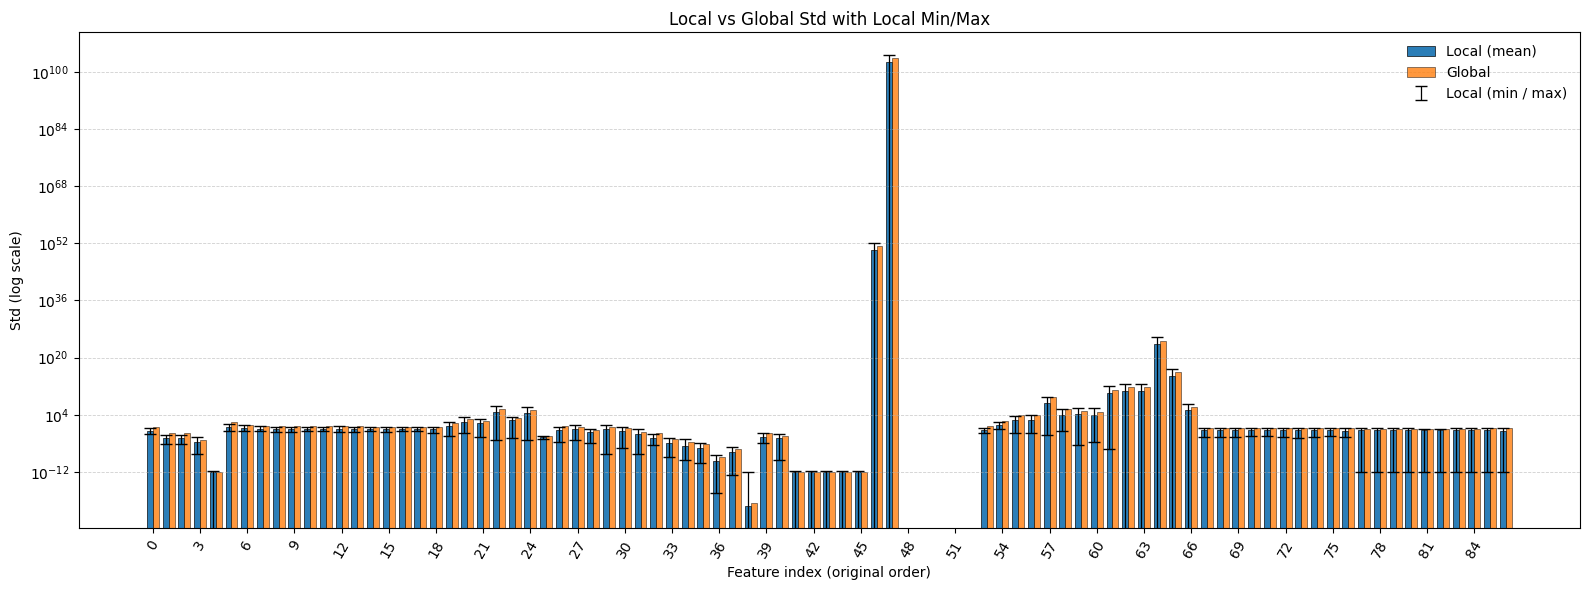

In [17]:
plot()